In [2]:
import pandas as pd
import numpy as np
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.model_selection import (
    cross_val_score,
    cross_validate,
    train_test_split,
)
from sklearn.linear_model import LinearRegression
from datetime import datetime, timedelta

from scipy.stats import norm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
import xgboost as xgb

In [14]:
df = pd.read_csv("data/jenny/final_preprocessed.csv")
df["date"] = pd.to_datetime(df["date"], format='%Y-%m-%d')
df.head(3)

,date,month,year,Temp,Flow,Level,count,october_Flow,november_Flow,december_Temp,...,rolling_Level_mean_5,rolling_Temp_std_15,rolling_Temp_std_10,rolling_Temp_std_5,rolling_Flow_std_15,rolling_Flow_std_10,rolling_Flow_std_5,rolling_Level_std_15,rolling_Level_std_10,rolling_Level_std_5
0,2013-09-02,9,2013,19.127273,0.8755,0.5480,0.0,7.679129,28.3825,3.965188,...,0.8237,2.160008,1.950006,1.571429,2.041962,1.416962,0.74561,0.060489,0.042766,0.024903
1,2013-09-03,9,2013,18.045833,0.7905,0.5405,0.0,7.679129,28.3825,3.965188,...,0.8237,2.160008,1.950006,1.571429,2.041962,1.416962,0.74561,0.060489,0.042766,0.024903
2,2013-09-04,9,2013,17.062500,0.7490,0.5365,0.0,7.679129,28.3825,3.965188,...,0.8237,2.160008,1.950006,1.571429,2.041962,1.416962,0.74561,0.060489,0.042766,0.024903


In [15]:
df['count_diff'] = df['count'].diff().dropna()

def create_lags(df, variable, start_lag, end_lag):
      n = start_lag
      while n <= end_lag:
            df[f"{variable}_lag_{n}"] = df[f"{variable}"].shift(n)
            n += 1
      return df

df = create_lags(df, "count", 31, 33)
df = create_lags(df, "Temp", 31, 33)
df = create_lags(df, "Flow", 31, 33)
df = create_lags(df, "Level", 31, 33)
df.tail(5)

,date,month,year,Temp,Flow,Level,count,october_Flow,november_Flow,december_Temp,...,count_lag_33,Temp_lag_31,Temp_lag_32,Temp_lag_33,Flow_lag_31,Flow_lag_32,Flow_lag_33,Level_lag_31,Level_lag_32,Level_lag_33
3767,2023-12-27,12,2023,6.758333,28.499999,1.2440,0.0,0.996387,3.854583,1.01586,...,0.0,0.837500,0.679167,0.804167,5.455,5.905,6.410,0.7865,0.8010,0.8170
3768,2023-12-28,12,2023,8.962500,30.200000,1.2460,0.0,0.996387,3.854583,1.01586,...,0.0,2.525000,0.837500,0.679167,5.090,5.455,5.905,0.7735,0.7865,0.8010
3769,2023-12-29,12,2023,8.366667,31.400000,1.2680,0.0,0.996387,3.854583,1.01586,...,0.0,2.120833,2.525000,0.837500,4.745,5.090,5.455,0.7615,0.7735,0.7865
3770,2023-12-30,12,2023,8.645833,23.600000,1.1695,0.0,0.996387,3.854583,1.01586,...,0.0,2.329167,2.120833,2.525000,4.455,4.745,5.090,0.7510,0.7615,0.7735
3771,2023-12-31,12,2023,6.516667,18.800000,1.0930,0.0,0.996387,3.854583,1.01586,...,0.0,2.525000,2.329167,2.120833,4.245,4.455,4.745,0.7425,0.7510,0.7615


In [34]:
df.columns

Index(['date', 'month', 'year', 'Temp', 'Flow', 'count', 'october_Flow',
       'november_Flow', 'december_Temp', 'january_Temp', 'feburary_Temp',
       'rolling_Temp_mean_15', 'rolling_Temp_mean_10', 'rolling_Temp_mean_5',
       'rolling_Flow_mean_15', 'rolling_Flow_mean_10', 'rolling_Flow_mean_5',
       'rolling_Temp_std_15', 'rolling_Temp_std_10', 'rolling_Temp_std_5',
       'rolling_Flow_std_15', 'rolling_Flow_std_10', 'rolling_Flow_std_5',
       'count_diff', 'count_lag_31', 'count_lag_32', 'count_lag_33',
       'Temp_lag_31', 'Temp_lag_32', 'Temp_lag_33', 'Flow_lag_31',
       'Flow_lag_32', 'Flow_lag_33'],
      dtype='object')

In [16]:
def impute_for_missing(df):
      missing_cols = df.columns[df.isna().any()].tolist()
      for col in missing_cols:
            median_value = df[col].median()
            df[col].fillna(median_value, inplace=True)
      return df

df = impute_for_missing(df)

In [19]:
def split_test_train(df, year=2023, summer_months=False):
      if summer_months:
            df = df[df["month"].isin([4,5,6,7,8])]
      train = df[df["year"] < year]
      test = df[df["year"] >= year]
      return train, test

train, test = split_test_train(df, year=2022, summer_months=True)
print(train.shape[0], test.shape[0])
print(train.shape[1], test.shape[1])

1224 306
45 45


In [28]:
def remove_features(df, keyword):
      keep = [col for col in df.columns.tolist() if keyword not in col]
      df = df[keep]
      return df

df = remove_features(df, "Level")
df.columns

Index(['date', 'month', 'year', 'Temp', 'Flow', 'count', 'october_Flow',
       'november_Flow', 'december_Temp', 'january_Temp', 'feburary_Temp',
       'rolling_Temp_mean_15', 'rolling_Temp_mean_10', 'rolling_Temp_mean_5',
       'rolling_Flow_mean_15', 'rolling_Flow_mean_10', 'rolling_Flow_mean_5',
       'rolling_Temp_std_15', 'rolling_Temp_std_10', 'rolling_Temp_std_5',
       'rolling_Flow_std_15', 'rolling_Flow_std_10', 'rolling_Flow_std_5',
       'count_diff', 'count_lag_31', 'count_lag_32', 'count_lag_33',
       'Temp_lag_31', 'Temp_lag_32', 'Temp_lag_33', 'Flow_lag_31',
       'Flow_lag_32', 'Flow_lag_33'],
      dtype='object')

In [37]:
use_for_feats = df.iloc[:,7:].columns.tolist()
use_for_feats.remove("count_diff")

# use_for_feats = ['month', 
#                  'october_Flow',
#                  'november_Flow',
#                  'december_Temp',
#                  'january_Temp',
#                  'feburary_Temp',
#                  'rolling_Temp_mean_5',
#                  'rolling_Flow_mean_5',
#                  'count_lag_31', 'count_lag_32', 'count_lag_33', 
#                  'Flow_lag_31', 'Flow_lag_32', 'Flow_lag_33', 
#                  'Temp_lag_31', 'Temp_lag_32', 'Temp_lag_33']

print(use_for_feats)

X_train = train[use_for_feats]
y_train = train['count_diff']

X_test = test[use_for_feats]
y_test = test['count_diff']

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1)
model.fit(X_train_scaled, y_train)

y_pred = model.predict(X_test_scaled)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'RMSE: {rmse}')

['november_Flow', 'december_Temp', 'january_Temp', 'feburary_Temp', 'rolling_Temp_mean_15', 'rolling_Temp_mean_10', 'rolling_Temp_mean_5', 'rolling_Flow_mean_15', 'rolling_Flow_mean_10', 'rolling_Flow_mean_5', 'rolling_Temp_std_15', 'rolling_Temp_std_10', 'rolling_Temp_std_5', 'rolling_Flow_std_15', 'rolling_Flow_std_10', 'rolling_Flow_std_5', 'count_lag_31', 'count_lag_32', 'count_lag_33', 'Temp_lag_31', 'Temp_lag_32', 'Temp_lag_33', 'Flow_lag_31', 'Flow_lag_32', 'Flow_lag_33']
RMSE: 188.40295613575552


In [31]:
test["pred"] = y_pred
test.tail(10)

,date,month,year,Temp,Flow,Level,count,october_Flow,november_Flow,december_Temp,...,Temp_lag_31,Temp_lag_32,Temp_lag_33,Flow_lag_31,Flow_lag_32,Flow_lag_33,Level_lag_31,Level_lag_32,Level_lag_33,pred
3640,2023-08-22,8,2023,16.787500,0.1810,0.5300,0.0,0.996387,3.854583,1.01586,...,21.154167,22.741667,23.387500,0.2870,0.2950,0.3145,0.5455,0.5455,0.5475,-0.840008
3641,2023-08-23,8,2023,15.562500,0.1845,0.5315,0.0,0.996387,3.854583,1.01586,...,20.191667,21.154167,22.741667,0.2775,0.2870,0.2950,0.5435,0.5455,0.5455,-3.064649
3642,2023-08-24,8,2023,15.841667,0.1945,0.5335,0.0,0.996387,3.854583,1.01586,...,18.258333,20.191667,21.154167,0.3950,0.2775,0.2870,0.5550,0.5435,0.5455,-1.487395
3643,2023-08-25,8,2023,17.858333,0.2030,0.5360,0.0,0.996387,3.854583,1.01586,...,15.641667,18.258333,20.191667,0.7395,0.3950,0.2775,0.5935,0.5550,0.5435,2.730566
3644,2023-08-26,8,2023,18.779167,0.2155,0.5390,0.0,0.996387,3.854583,1.01586,...,16.820833,15.641667,18.258333,0.6475,0.7395,0.3950,0.5860,0.5935,0.5550,-11.743644
3645,2023-08-27,8,2023,21.737500,0.2160,0.5400,0.0,0.996387,3.854583,1.01586,...,17.979167,16.820833,15.641667,0.5640,0.6475,0.7395,0.5740,0.5860,0.5935,-12.996211
3646,2023-08-28,8,2023,20.358333,0.2120,0.5395,0.0,0.996387,3.854583,1.01586,...,19.812500,17.979167,16.820833,0.5225,0.5640,0.6475,0.5690,0.5740,0.5860,-11.469485
3647,2023-08-29,8,2023,16.691667,0.2575,0.5455,0.0,0.996387,3.854583,1.01586,...,19.520833,19.812500,17.979167,0.4690,0.5225,0.5640,0.5640,0.5690,0.5740,-2.174296
3648,2023-08-30,8,2023,17.050000,0.2555,0.5445,0.0,0.996387,3.854583,1.01586,...,18.491667,19.520833,19.812500,0.4180,0.4690,0.5225,0.5590,0.5640,0.5690,5.261849
3649,2023-08-31,8,2023,17.204167,0.2805,0.5480,0.0,0.996387,3.854583,1.01586,...,18.312500,18.491667,19.520833,0.3800,0.4180,0.4690,0.5540,0.5590,0.5640,-2.309231


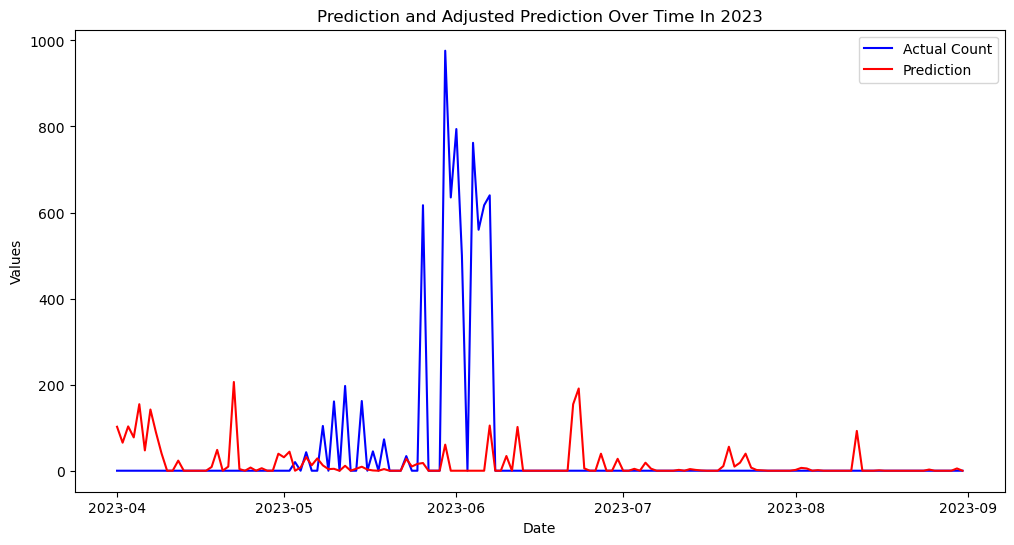

In [32]:
def plot_model(df, subset_year=None):
      df = df.set_index("date")
      if subset_year != None:
            df = df[df["year"] == subset_year]
      adjust_val = lambda row: 0 if row["pred"] <= 0 else row["pred"]
      if "pred_adjust" not in df.columns.tolist():
            df["pred_adjust"] = df.apply(adjust_val, axis=1)

      plt.figure(figsize=(12, 6))
      plt.plot(df.index, df['count'], label='Actual Count', color='blue')
      plt.plot(df.index, df['pred_adjust'], label='Prediction', color='red')

      plt.title(f'Prediction and Adjusted Prediction Over Time In {subset_year}')
      plt.xlabel('Date')
      plt.ylabel('Values')

      plt.legend()
      plt.show()

plot_model(test, 2023)

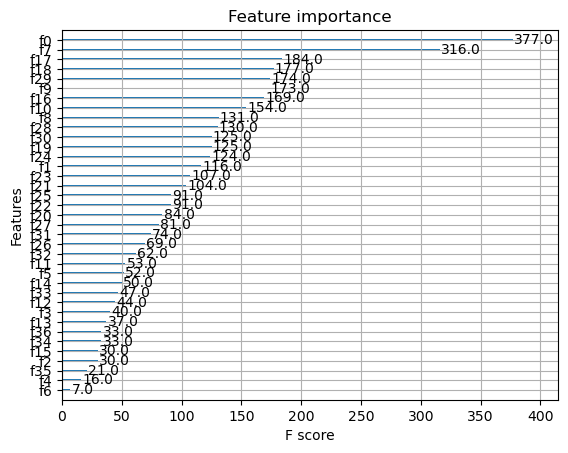

In [26]:
xgb.plot_importance(model)
plt.show()